In [1]:
import pandas as pd
# from pandas.api.types import CategoricalDtype
import json
from sklearn.feature_selection import VarianceThreshold


In [2]:
meta = pd.read_csv('../data/FFMetadata_v10.csv',low_memory=False)
df = pd.read_csv('../data/FFChallenge_v5/background.csv',low_memory=False,index_col=0,na_values=[-9,-8,-6,-5,-4,-3,-2,-1])
constant = pd.read_csv('../data/FFChallenge_v5/constantVariables.txt',header=None,index_col=0)

print(f'Background: {df.shape[1]} variables')

print(f'Meta: {meta.shape[0]} variables')

print(f'Constant: {constant.shape[0]} variables')

Background: 13026 variables
Meta: 25684 variables
Constant: 2432 variables


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4242 entries, 1 to 4242
Columns: 13026 entries, cf1intmon to k5f1
dtypes: float64(12880), int64(30), object(116)
memory usage: 421.6+ MB


In [4]:
df.columns[df.columns.isin(meta.new_name)]

Index(['cf1intmon', 'cf1intyr', 'cf1lenhr', 'cf1lenmin', 'cf1twoc', 'cf1fint',
       'cf1natsm', 'f1natwt', 'cf1natsmx', 'f1natwtx',
       ...
       'q5citywt_rep63', 'q5citywt_rep64', 'q5citywt_rep65', 'q5citywt_rep66',
       'q5citywt_rep67', 'q5citywt_rep68', 'q5citywt_rep69', 'q5citywt_rep70',
       'q5citywt_rep71', 'q5citywt_rep72'],
      dtype='object', length=12840)

# Drop constantVariables.txt

In [5]:
df.drop(constant.index.values,axis=1,inplace=True)
delcols = df.std()[df.std() == 0].index
df.drop(delcols,axis=1,inplace=True)

print(f'Background without constant: {df.shape[1]} variables')

/tmp/ipykernel_21922/1791826707.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  delcols = df.std()[df.std() == 0].index


Background without constant: 10211 variables


/tmp/ipykernel_21922/1791826707.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  delcols = df.std()[df.std() == 0].index


In [6]:
# Drop one copy of identical variables

df = df.loc[:,~df.T.duplicated(keep='first')]

print(f'Background without constant and duplicates: {df.shape[1]} variables')

Background without constant and duplicates: 10069 variables


# Drop columns with excessive real missing values

In [7]:
def dropvars(df,nan_threshold=0.7):
    # thresh = Require that many non-NA values 
    return df.dropna(thresh=len(df)*nan_threshold, axis=1)

df = dropvars(df)

df

,cf1lenmin,cf1fint,cf1citsm,f1citywt,f1a2,f1a3,f1a4,f1a5,f1a6,f1b1a,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
challengeID,,,,,,,,,,,,,,,,,,,,,
1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.269946,5.180325,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
2,40.0,1,1.0,68.455658,2.0,1.0,1.0,1.0,1.0,1.0,...,6.269946,27.680196,2.511131,1.718804,6.473537,16.369411,26.671897,9.628369,15.981275,3.667679
3,45.0,1,1.0,42.319057,1.0,1.0,1.0,1.0,2.0,3.0,...,6.269946,5.180325,20.867881,24.115867,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
4,45.0,1,1.0,25.628830,1.0,1.0,1.0,1.0,2.0,3.0,...,6.269946,5.180325,22.018875,22.932641,6.473537,-5.169243,4.476881,9.628369,-6.303171,4.140511
5,50.0,1,1.0,41.954487,2.0,1.0,1.0,1.0,2.0,4.0,...,6.269946,5.180325,22.916602,22.988036,6.473537,-6.034660,4.476881,9.628369,-6.211828,3.668879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.941956,5.180325,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
4239,40.0,1,1.0,64.195152,2.0,1.0,1.0,1.0,2.0,0.0,...,28.703663,5.180325,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,3.424922
4240,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.269946,26.990283,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266


In [8]:
print(f'Background without excessive missing values: {df.shape[1]} variables')

Background without excessive missing values: 1593 variables


# Select survey and constructed variables

In [9]:
cols = [col for col in df.columns if col in meta.new_name.values]

# dtypes[dtypes.new_name == 'cf4fint']
# string = '1960-01-02'
# mask = df.isin(['1960-01-01']).any()
# df.columns[mask]

malformed = {
    'r3b26_a': 'Has text instead of numerical encodings',
    'cf4fint': 'cf4fint encoded as binary but has 1960-01-01',
    'm5f23a': 'Used in target variable',
    'n5g1e': 'Used in target variable',
    'n5g1j': 'Used in target variable',
    'm5f23e': 'Used in target variable',
    'm5f23k': 'Used in target variable',
    'm5f23c': 'Used in target variable',
    'f5f23c': 'Used in target variable',
}

for key in malformed.keys():
    if key in cols:
        cols.remove(key)
        print(f'Removed {key} from cols')

# get only questionnaire and constructed variables

meta = meta[meta.new_name.isin(cols)][meta.source.isin(['questionnaire','constructed'])]

cols = meta[meta.topics != 'Paradata and weights'].new_name

df = df[cols]

print(f'Background without malformed variables: {df.shape[1]} variables')

Removed cf4fint from cols
Removed m5f23a from cols
Removed n5g1e from cols
Removed n5g1j from cols
Removed m5f23e from cols
Removed m5f23k from cols
Removed m5f23c from cols
Background without malformed variables: 1431 variables


/tmp/ipykernel_21922/596351072.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meta = meta[meta.new_name.isin(cols)][meta.source.isin(['questionnaire','constructed'])]


# Drop cols with low-variance

In [10]:
pd.options.display.float_format = '{:.2f}'.format

df.var().describe()

count         1431.00
mean       5194486.19
std       70228814.63
min              0.00
25%              0.13
50%              0.32
75%              1.67
max     1228819128.68
dtype: float64

<Axes: >

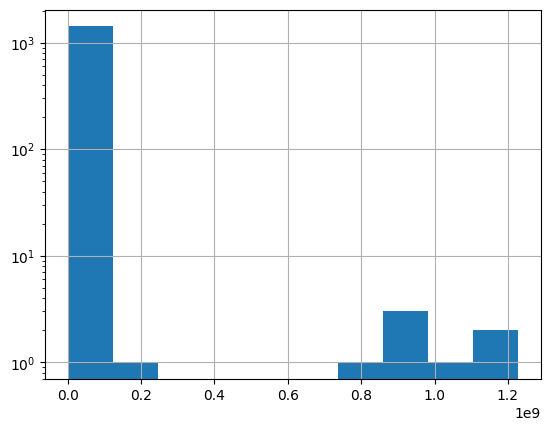

In [11]:
df.var().hist(bins=10,log=True)

In [12]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(df)
df = df[df.columns[sel.get_support(indices=True)]]
print(f'Background without low variance: {df.shape[1]} variables')

Background without low variance: 1411 variables


In [13]:
pd.options.display.float_format = '{:.2f}'.format

df.var().describe()

count         1411.00
mean       5268114.62
std       70722393.33
min              0.01
25%              0.14
50%              0.36
75%              1.72
max     1228819128.68
dtype: float64

# Remove by type of variable

In [14]:
meta.source.value_counts()

questionnaire    1296
constructed       196
Name: source, dtype: int64

In [15]:
meta[meta.new_name.isin(cols)].source.value_counts()

questionnaire    1289
constructed       142
Name: source, dtype: int64

## Check datatypes and topics

In [16]:
meta[meta.new_name.isin(cols)].type.value_counts()

Binary                   692
Ordered Categorical      469
Continuous               135
Unordered Categorical    135
Name: type, dtype: int64

In [17]:
meta[meta.new_name.isin(cols)].topics.value_counts().head(15)

Health and health behavior                 191
Finances                                   159
Housing and neighborhood                   138
Parenting                                  109
Romantic relationships                     100
Attitudes and expectations                  88
Family and social ties                      75
Education and school                        70
Employment                                  64
Cognitive and behavioral development        63
Housing and neighborhood ; Demographics     39
Finances ; Housing and neighborhood         27
Legal system                                23
Parenting ; Romantic relationships          20
Demographics                                15
Name: topics, dtype: int64

# Export metadata

In [18]:
myvars = meta[meta.new_name.isin(cols)].copy()

myvars['one_topic'] = myvars['topics'].str.split(';').str[0]

# trim one topic
myvars['one_topic'] = myvars['one_topic'].str.strip()

# remove space and upper case
myvars['one_topic'] = myvars['one_topic'].str.replace(' ','_').str.lower()

dtypes = myvars[['new_name','varlab','type','one_topic']].copy()

dtypes

,new_name,varlab,type,one_topic
13,f1a2,Were you present at the birth?,Binary,parenting
14,f1a3,Have you held baby(ies)?,Binary,parenting
15,f1a4,Will the baby(ies) have your last name?,Binary,parenting
17,f1a5,Will your name be on the birth certificate?,Binary,parenting
19,f1a6,Do you have other biological children?,Binary,health_and_health_behavior
...,...,...,...,...
12779,cm5edu,Constructed - Mother's education: year 9,Ordered Categorical,education_and_school
12781,cm5hhinc,Constructed - Mother's Household income (with ...,Continuous,finances
12783,cm5hhimp,Flag var for household income imputation - mot...,Unordered Categorical,finances
12787,cm5povco,Constructed - Mother's household income/povert...,Continuous,finances


In [19]:
ordcat_list = dtypes[dtypes.type == 'Ordered Categorical']

dictdtype = {
    'Binary': 'float64', 
    # 'Ordered Categorical': CategoricalDtype(categories=ordcat_list, ordered=True),
    'Ordered Categorical': 'float64',
    'Continuous': 'float64',
    'Unordered Categorical': 'category',
}

dtypes['dtype'] = dtypes.type.map(dictdtype)

# Export metadata.json

In [20]:
dtypes_dict = dict(zip(dtypes.new_name,dtypes.dtype))
dtypes_dict = {'challengeID': 'int64', **dtypes_dict}

# dtypes_dict = {k: str(v) if isinstance(v, CategoricalDtype) else v for k, v in dtypes_dict.items()}

with open('../metadata/metadata.json', 'w') as fp:
    json.dump(dtypes_dict, fp)

In [21]:
pd.read_csv('../data/FFChallenge_v5/background.csv',low_memory=False, \
                            dtype=dtypes_dict,\
                            usecols=dtypes_dict.keys()).set_index('challengeID')

,f1a2,f1a3,f1a4,f1a5,f1a6,f1b1a,f1b2,f1b26,f1b27,f1b28,...,cm5md_case_lib,cn5md_case_con,cn5md_case_lib,cm5finjail,cm5fevjail,cm5edu,cm5hhinc,cm5hhimp,cm5povco,cm5povca
challengeID,,,,,,,,,,,,,,,,,,,,,
1,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,...,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9,-9.00,-9.00
2,2.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,2.00,2.00,...,0.00,-7.00,-7.00,0.00,0.00,1.00,4337.16,4,0.84,1.00
3,1.00,1.00,1.00,1.00,2.00,3.00,1.00,1.00,2.00,2.00,...,-9.00,-7.00,-7.00,-9.00,-9.00,-9.00,-9.00,-9,-9.00,-9.00
4,1.00,1.00,1.00,1.00,2.00,3.00,2.00,1.00,2.00,2.00,...,0.00,-7.00,-7.00,0.00,0.00,4.00,62960.56,1,2.76,4.00
5,2.00,1.00,1.00,1.00,2.00,4.00,2.00,1.00,2.00,2.00,...,0.00,-7.00,-7.00,0.00,0.00,2.00,11631.77,1,0.74,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,...,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9,-9.00,-9.00
4239,2.00,1.00,1.00,1.00,2.00,0.00,2.00,3.00,2.00,2.00,...,1.00,-7.00,-7.00,0.00,1.00,1.00,24696.79,4,0.98,2.00
4240,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,...,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9,-9.00,-9.00


In [22]:
dtypes[dtypes.new_name == 'p5q3by']

,new_name,varlab,type,one_topic,dtype


In [23]:
dtypes.to_csv('../metadata/variables.csv',index=False)